In [1]:
import os,sys
sys.path.insert(0,'../../libs')
import openai
from llm_utils import BSAgent
from data_utils import train_val_test_split,load_split_climate_data
import pandas as pd
import re,json,copy
from tqdm import tqdm
from prompts import short_cot_pt,short_cot_pt_2label,long_cot_pt,long_cot_pt_2label
import pprint

In [2]:
from pydantic import BaseModel
from typing import Literal

In [3]:
from dotenv import load_dotenv
env_path = '../../../.env'
load_dotenv(dotenv_path=env_path)
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("OPENAI_API_KEY not found in environment variables. Please check your .env file.")


In [4]:
data_folder = '/Users/huang/Dev/Protagolabs_works/data/Fund/Climate'
data_path = os.path.join(data_folder,'Climate training paragraphs.csv')
ds = load_split_climate_data(data_path,merge_neutral=True,verbose=True)

Label distribution:
label
favorable      0.552778
unfavorable    0.447222
Name: proportion, dtype: float64


In [5]:
class ClimateClassification(BaseModel):
    justification: str
    classification: Literal["favorable", "unfavorable", "neutral"]

class ClimateClassification_2label(BaseModel):
    justification: str
    classification: Literal["favorable", "unfavorable"]


In [7]:
def get_climate_classifications(agent, dataset, prompt_template):
    results = []
    for i in tqdm(range(len(dataset))):
        structured_prompt = copy.deepcopy(prompt_template)
        structured_prompt['user'] = structured_prompt['user'].format(PARAGRAPH=dataset.iloc[i].paragraph)
        try:
            response = agent.get_response_content(prompt_template=structured_prompt, response_format=ClimateClassification)
            results.append({
                'paragraph': dataset.iloc[i].paragraph,
                'true_label': dataset.iloc[i].label,
                'predicted_label': response.classification,
                'justification': response.justification
            })
        except Exception as e:
            print(f"Error processing row {i}: {str(e)}")
            results.append({
                'paragraph': dataset.iloc[i].paragraph,
                'true_label': dataset.iloc[i].label,
                'predicted_label': None,
                'justification': f"Error: {str(e)}"
            })
    return pd.DataFrame(results)

In [11]:
agent = BSAgent(model='gpt-4o-mini')

In [12]:
# # Get predictions for validation and test sets
# val_results = get_climate_classifications(agent, ds['validation'], short_cot_pt)
# test_results = get_climate_classifications(agent, ds['test'], short_cot_pt)

# Get predictions for validation and test sets
val_results = get_climate_classifications(agent, ds['validation'], long_cot_pt_2label)
#test_results = get_climate_classifications(agent, ds['test'], long_cot_pt_2label)

print("\nValidation Results:")
print(f"Total samples: {len(val_results)}")
print(f"Successfully processed: {len(val_results[val_results.predicted_label.notna()])}")

# print("\nTest Results:")
# print(f"Total samples: {len(test_results)}")
# print(f"Successfully processed: {len(test_results[test_results.predicted_label.notna()])}")

# Calculate accuracy for validation set
val_accuracy = (val_results['true_label'] == val_results['predicted_label']).mean()
print(f"Validation Accuracy: {val_accuracy:.2%}")

# # Calculate accuracy for test set 
# test_accuracy = (test_results['true_label'] == test_results['predicted_label']).mean()
# print(f"Test Accuracy: {test_accuracy:.2%}")

100%|██████████| 108/108 [02:31<00:00,  1.41s/it]


Validation Results:
Total samples: 108
Successfully processed: 108
Validation Accuracy: 65.74%


Fontconfig warning: ignoring UTF-8: not a valid region tag


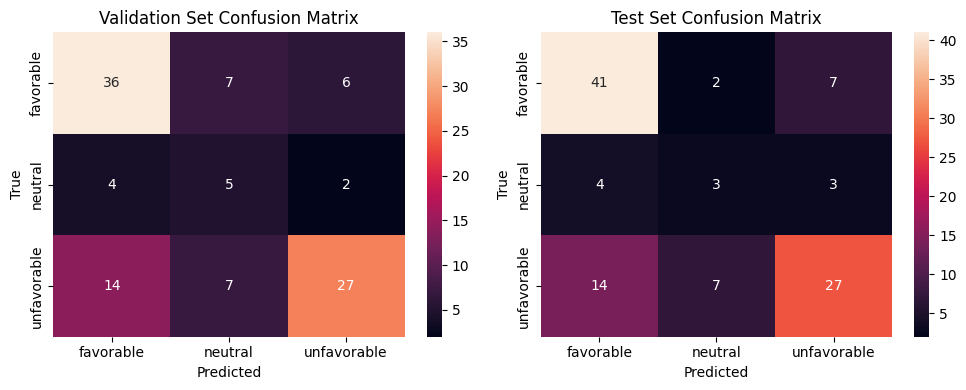

In [42]:
# Create confusion matrices
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the labels
labels = ['favorable', 'neutral', 'unfavorable']

# Create confusion matrix for validation set
val_cm = confusion_matrix(val_results['true_label'], val_results['predicted_label'], labels=labels)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(val_cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Create confusion matrix for test set
test_cm = confusion_matrix(test_results['true_label'], test_results['predicted_label'], labels=labels)
plt.subplot(1, 2, 2)
sns.heatmap(test_cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


In [35]:
val_results.to_csv(data_folder+'/val_results.csv')
test_results.to_csv(data_folder+'/test_results.csv')